In [14]:
import pandas as pd

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [16]:
data0 = 'prescient-coding-challenge-2024/data/data0.csv'
data1 = 'prescient-coding-challenge-2024/data/data1.csv'
returns = 'prescient-coding-challenge-2024/data/returns.csv'

import pathlib

# check if file exists
for file in [data0, data1, returns]:
    if not pathlib.Path(file).exists():
        print(f'File {file} does not exist')

In [17]:
data0 = pd.read_csv(data0)
data1 = pd.read_csv(data1)
returns = pd.read_csv(returns)

In [18]:
data = pd.merge(data1, data0[['security', 'sector']], on='security', how='left')

In [19]:
data

,date,security,price,return30,ratio_pe,ratio_pcf,ratio_de,ratio_roe,ratio_roa,label,sector
0,2017-01-03,AAPL,29.04,0.056769,3.477844,-4.570000e-08,-59.647701,0.464198,0.561660,0,Information Technology
1,2017-01-04,AAPL,29.01,0.063416,3.474251,-4.560000e-08,-59.647701,0.464198,0.561660,1,Information Technology
2,2017-01-05,AAPL,29.15,0.060386,3.491018,-4.580000e-08,-59.647701,0.464198,0.561660,1,Information Technology
3,2017-01-06,AAPL,29.48,0.061960,3.530539,-4.640000e-08,-59.647701,0.464198,0.561660,1,Information Technology
4,2017-01-09,AAPL,29.75,0.044226,3.562874,-4.680000e-08,-59.647701,0.464198,0.561660,1,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...
182175,2024-06-24,XOM,114.05,0.005555,12.829021,5.993169e-08,19.934807,-0.118059,-2.743666,1,Energy
182176,2024-06-25,XOM,114.37,0.008376,12.865017,6.009984e-08,19.934807,-0.118059,-2.743666,1,Energy
182177,2024-06-26,XOM,114.41,0.008729,12.869516,6.012086e-08,19.934807,-0.118059,-2.743666,1,Energy
182178,2024-06-27,XOM,114.90,0.000348,12.924634,6.037835e-08,19.934807,-0.118059,-2.743666,1,Energy


In [20]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])
returns['date'] = pd.to_datetime(returns['date'])

In [21]:
# Sort the data by date and security
data = data.sort_values(['date', 'security'])
returns = returns.sort_values(['date', 'security'])


In [22]:
data.head()

,date,security,price,return30,ratio_pe,ratio_pcf,ratio_de,ratio_roe,ratio_roa,label,sector
0,2017-01-03,AAPL,29.04,0.056769,3.477844,-4.570000e-08,-59.647701,0.464198,0.561660,0,Information Technology
1884,2017-01-03,ABBV,62.41,0.050143,17.098630,-1.890000e-08,-11.499223,0.682651,0.579724,1,Health Care
3768,2017-01-03,ABT,39.05,0.030343,41.542553,2.867318e-09,1.518761,6.315856,0.118950,1,Health Care
5652,2017-01-03,ACN,116.46,-0.007076,17.699088,2.137496e-07,69.627283,0.643869,0.401666,1,Information Technology
7536,2017-01-03,ADBE,103.48,0.037602,44.034043,7.679121e-07,281.517849,2.027407,0.255764,1,Information Technology


Training data shape: (167780, 16)
Testing data shape: (12400, 16)
Class balance in training set:
label
1    0.525641
0    0.474359
Name: proportion, dtype: float64


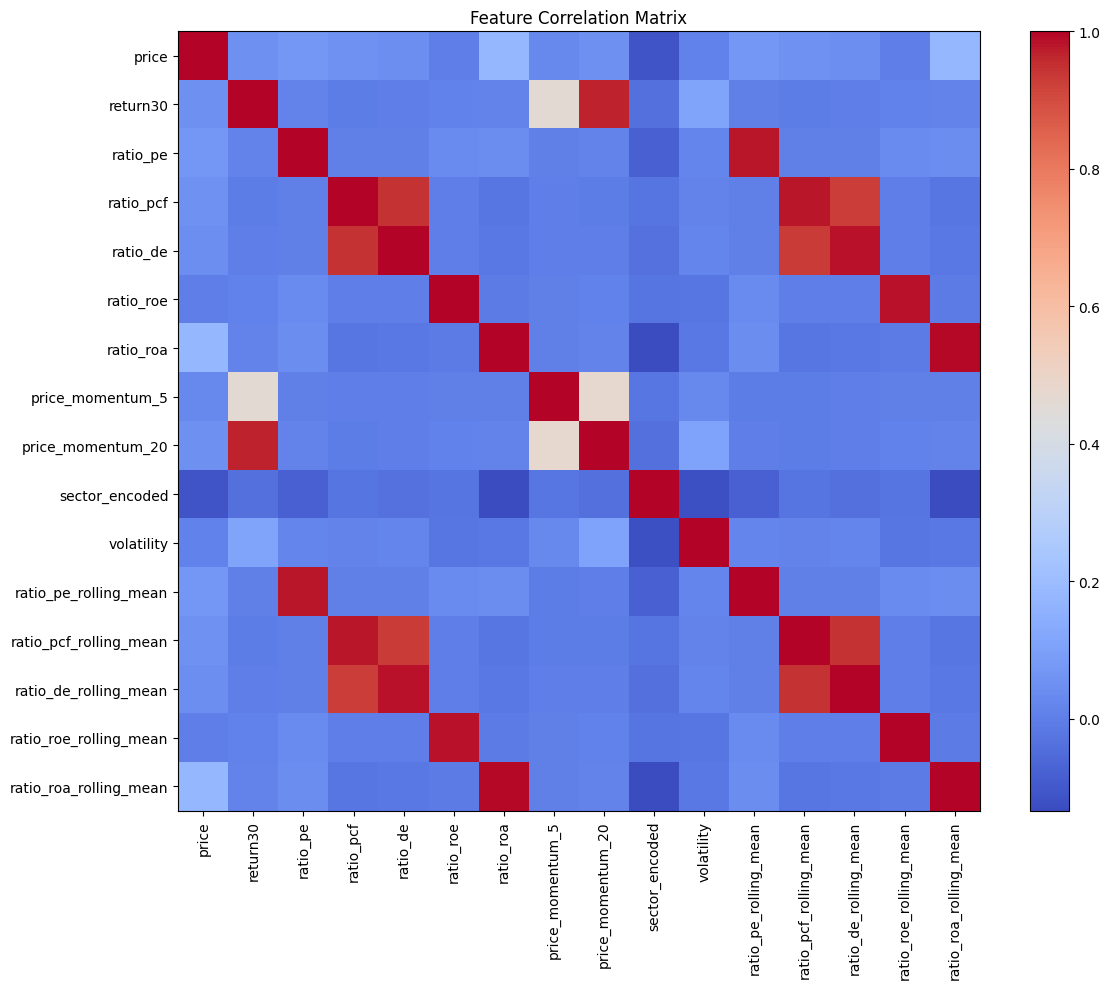

In [23]:
# Feature Engineering
def add_features(df):
    # Price momentum
    df['price_momentum_5'] = df.groupby('security')['price'].pct_change(5)
    df['price_momentum_20'] = df.groupby('security')['price'].pct_change(20)
    
    # Rolling mean of ratios
    for ratio in ['ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa']:
        df[f'{ratio}_rolling_mean'] = df.groupby('security')[ratio].rolling(window=20).mean().reset_index(0, drop=True)
    
    # Sector encoding
    df['sector_encoded'] = pd.factorize(df['sector'])[0]
    
    # Rolling volatility
    df['volatility'] = df.groupby('security')['return30'].rolling(window=20).std().reset_index(0, drop=True)
    
    return df

# Apply feature engineering
data = add_features(data)

# Drop rows with NaN values resulting from rolling calculations
data = data.dropna()

# Prepare features and target
features = ['price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa',
            'price_momentum_5', 'price_momentum_20', 'sector_encoded', 'volatility',
            'ratio_pe_rolling_mean', 'ratio_pcf_rolling_mean', 'ratio_de_rolling_mean',
            'ratio_roe_rolling_mean', 'ratio_roa_rolling_mean']

X = data[features]
y = data['label']

# Split the data
train_data = data[data['date'] < '2024-01-01']
test_data = data[data['date'] >= '2024-01-01']

X_train = train_data[features]
y_train = train_data['label']
X_test = test_data[features]
y_test = test_data['label']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Check class balance
print("Class balance in training set:")
print(y_train.value_counts(normalize=True))

# Correlation analysis
correlation_matrix = X_train.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [25]:
selected_features = ['price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa',
                     'price_momentum_5', 'sector_encoded', 'volatility']

In [26]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale the selected features
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      5879
           1       0.53      0.51      0.52      6521

    accuracy                           0.51     12400
   macro avg       0.51      0.51      0.51     12400
weighted avg       0.51      0.51      0.51     12400

ROC AUC Score: 0.5036505764580858

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.49      0.07      0.12      5879
           1       0.53      0.94      0.68      6521

    accuracy                           0.53     12400
   macro avg       0.51      0.50      0.40     12400
weighted avg       0.51      0.53      0.41     12400

ROC AUC Score: 0.5087191188012592

Random Forest - Top 5 important features:
            feature  importance
7  price_momentum_5    0.163796
1          return30    0.159930
9        volatility    0.159654
2          ratio_pe    0.136690
0             pr

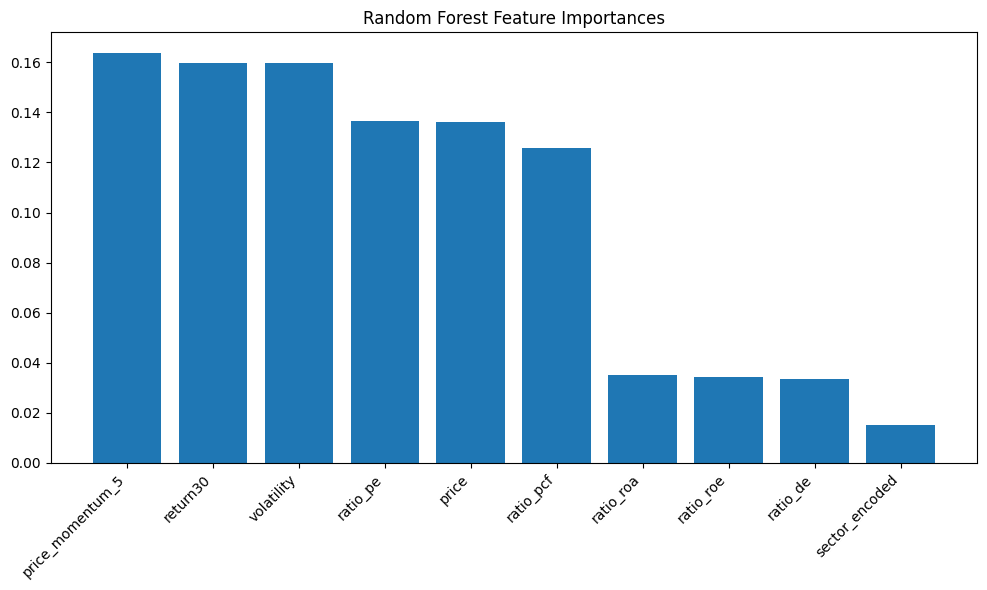

In [27]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_selected, y_train)
rf_pred = rf_model.predict(X_test_scaled_selected)
rf_pred_proba = rf_model.predict_proba(X_test_scaled_selected)[:, 1]

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_pred_proba))

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled_selected, y_train)
gb_pred = gb_model.predict(X_test_scaled_selected)
gb_pred_proba = gb_model.predict_proba(X_test_scaled_selected)[:, 1]

print("\nGradient Boosting Performance:")
print(classification_report(y_test, gb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, gb_pred_proba))

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)
print("\nRandom Forest - Top 5 important features:")
print(rf_feature_importance.head())

# Plot Random Forest feature importance
plt.figure(figsize=(10, 6))
plt.bar(rf_feature_importance['feature'], rf_feature_importance['importance'])
plt.title("Random Forest Feature Importances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
test_data['buy_signal'] = gb_model.predict_proba(X_test_scaled_selected)[:, 1]

# Create buy matrix
buy_matrix = test_data.pivot(index='date', columns='security', values='buy_signal')

# Select top 10 stocks each day
def select_top_10(row):
    top_10 = row.nlargest(10)
    return [1 if x in top_10 else 0 for x in row]

buy_matrix = buy_matrix.apply(select_top_10, axis=1)

print("Buy matrix shape:", buy_matrix.shape)
print("\nSample of buy matrix:")


Buy matrix shape: (124,)

Sample of buy matrix:


/tmp/ipykernel_9401/1172228163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['buy_signal'] = gb_model.predict_proba(X_test_scaled_selected)[:, 1]


date
2024-05-20    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2024-02-09    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2024-03-08    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2024-03-04    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2024-05-23    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

In [33]:
# sum all the values in the matrix



ValueError: No axis named 1 for object type Series

In [ ]:
buy_matrix.sample(5)